# CS-E4870 Research Project in Machine Learning and Data Science
**Topic 17: Learning to communicate optimally**

**Author: Juhani Viinanen(juhani.viinanen@aalto.fi)**

This notebook is a project done for the course CS-E4870 Research Project in Machine Learning and Data Science. The topic of the project itself is the "learning" of communication, which in the context of this project means using deep learning techniques to model both the transmitter and  the receiver as deep neural nets that learn to reliably communicate over a noisy channel.

The simplest way in which this is done, is to model the whole communication system as an autoencoder. An autoencoder is a type of neural network that learns an efficient encoding for its input in an unsupervised manner. In our case the inputs are the N different messages that we wish to transmit over the channel, and the encoding is the constellation diagram.

For more information on autoencoders and constellation diagrams:
https://en.wikipedia.org/wiki/Autoencoder \\
https://en.wikipedia.org/wiki/Constellation_diagram

In [3]:
# Importing packages we will use
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from matplotlib.pyplot import scatter

# Disable tensorflow error messages
tf.logging.set_verbosity(tf.logging.ERROR)
# RUN THIS CELL AGAIN TO GET RID OF THE ERROR MESSAGES (IF ANY APPEAR)

ModuleNotFoundError: No module named 'tensorflow'

# Part 1: Communication system as an autoencoder

In this part we demonstrate how a communication system (transmitter + channel + receiver) can be modelled as an autoencoder. We build an autoencoder model, train it, and then create a scatter plot of the encoded messages. The model for the autoencoder is very simple with only a few layers and nodes.

We use a one-hot encoding on the input data and use Softmax loss i.e. our output layer has a softmax activation and we use cross-entropy loss. Another benefit of representing the messages with a one-hot encoding is that we can use an identity matrix as our data, both input and target, since the aim of an autoencoder is reconstruction of the input data.

In [2]:
# number of different messages N
N = 8
data = np.identity(N)

In [3]:
# Here we build the actual model
model = tf.keras.Sequential([
    layers.Dense(32, activation="relu", input_shape = (N,)),
    layers.Dense(2, activation="linear", name = "channel_output"), # This layer is used later to draw samples for plotting
    layers.BatchNormalization(),
    layers.GaussianNoise(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dense(N, activation="softmax")
])
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(0.01),
             loss = "categorical_crossentropy")

In [4]:
# This cell trains the model, 500 epochs should be enough
model.fit(data, data, epochs = 500, batch_size = N, verbose = 0)

In [5]:
# Here we make a model to get the "encoded" outputs from the middle of the autoencoder so we can plot them
channel_output_model = tf.keras.models.Model(inputs = model.input, outputs = model.get_layer("channel_output").output)

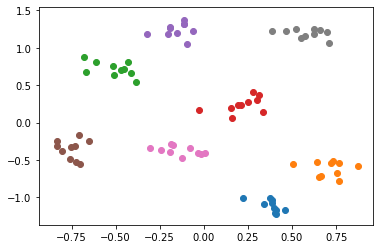

In [6]:
# This cell plots our constellation diagram
output_data = channel_output_model.predict(data)
# Number of samples for each point n
n = 10

for data_point in output_data:
    x1 = np.repeat(data_point[0],n) + np.random.normal(scale = 0.1, size = n)
    x2 = np.repeat(data_point[1],n) + np.random.normal(scale= 0.1, size = n)
    scatter(x1,x2)

The above scatter plot should show each sent message with different colours. Since tensorflow can't handle complex numbers our model actually has two real numbers in place of a single complex number, but the end result should be pretty identical.

# Part 2: Unknown Channel

The obvious flaw with the approach in part 1 to learning a transmitter and a receiver is quite obvious: it requires the channel model to be differentiable, which in real life situations is pretty much never the case. If the channel model was not differentiable in part 1, then we could not use deep learning techniques(backpropagation) to learn the transmitter function. While the receiver could still be optimized on just the channel outputs, this would lead to subpar perfomance.

A solution to learning an autoencoder over an unknown channel is presented in the research paper:

_End-to-End Learning of Communications Systems Without a Channel Model_, by Fayçal Ait Aoudia and Jakob Hoydis, https://arxiv.org/pdf/1804.02276.pdf.

Our solution, while inspired by the research paper, is a bit simpler. We simply split the autoencoder of part 1 into two, a transmitter and a receiver, that train alternatively. The training of the receiver is easy, it's a supervised learning task with the channel outputs as its inputs. The training of the transmitter is a bit trickier and is explained in pseudocode here:

1. Generate transmitter output X, from identity matrix input
2. Generate Xp, which is X with gaussian noise added
3. Transmit X and Xp over the channel; Receive Y and Yp at the receiver
4. Calculate loss for Y and Yp
5. If loss for Yp is less than for Y, train transmitter with Xp as the target
6. Else create new Xp, transmit it over the channel, and calculate loss again

Then we just alternate the training of the transmitter and the receiver.

In [7]:
# Transmitter model
transmitter = tf.keras.Sequential([
    layers.Dense(32, activation="relu", input_shape = (N,)),
    layers.Dense(2, activation="linear")
])

# Receiver model
receiver = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(N, activation="softmax")
])

# Compile the models
transmitter.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss = "mean_squared_error")
receiver.compile(optimizer = tf.keras.optimizers.Adam(0.01), loss = "categorical_crossentropy")

# Channel transfer function
def transmit(input):
    return input + np.random.normal(size = input.shape)

In [8]:
# Functions for alternative training of reveiver and the transmitter
def train_receiver():
    receiver_input = transmit(transmitter.predict(data))
    receiver.fit(receiver_input, data, epochs = 1, batch_size = N, verbose = 0)

def train_transmitter():
    current_loss = receiver.evaluate(transmit(transmitter.predict(data)), data, verbose = 0)
    x = transmitter.predict(data)
    for i in range(20):
        xp = x + np.random.normal(size = x.shape)
        new_loss = receiver.evaluate(transmit(xp), data, verbose = 0)
        # See if new input achieves a smaller loss
        if new_loss < current_loss:
            transmitter.fit(data, xp, epochs = 1, batch_size = N, verbose = 0)
            return 1
    return 0

In [9]:
# Alternative training of the transmitter and the receiver, 
for i in range(500):
    train_receiver()
    train_transmitter()

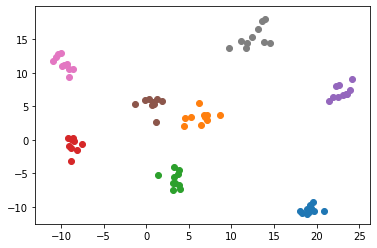

In [10]:
# Print results
temp = transmitter.predict(data)
# Number of samples for each point n
n = 10

for data_point in temp:
    x1 = np.repeat(data_point[0],n) + np.random.normal(size = n)
    x2 = np.repeat(data_point[1],n) + np.random.normal(size = n)
    scatter(x1,x2)

The above scatter plot should look pretty similiar to the scatter plot of part 1, with the messages being in distinct clusters. It also proves that our model does learn to encode and decode messages over the unknown channel.

# Conclusions

This project was pretty much just a demonstration of a concept, that is of learning a communication scheme over an unknown channel model using deep leaning techniques. There is however a major problem with the technique:
-  We actually require a reliable channel between the transmitter and the receiver during training, to tell the transmitter whether the loss on Xp is less than the loss on X

The authors of https://arxiv.org/pdf/1804.02276.pdf, however say that they are working on a training method that does not require a feedback channel, but until such a method is developed, this technique of learning a communication scheme is not really usable in real world scenarios that lack them.